In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import os
import pickle

import cl_gym as cl
from metrics import MetricCollector2, FairMetricCollector
from configs import make_params

EER_dataset = ["MNIST", "FashionMNIST", "CIFAR10", "CIFAR100"]
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
LOG_PATH = f"scripts_output_rebuttal"
OUT_PATH = f"outputs_rebuttal"

def is_number(value):
    flag=True
    try:
        num=float(value)
        flag = num == num
    except ValueError:
        flag=False
    return flag


def load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, fair_metric, eps=None, randinx = False, verbose=2):
    # if dataset == "CIFAR10":
    #     dataset+="(prev)"
    path = f"dataset={dataset}"
    if randinx:
        path+="_randidx"
    if eps is None:
        eps = 0
    # if method != "FSW":
    #     fair_metric = "no_metrics"
    path = os.path.join(path, method)
    path = os.path.join(path, fair_metric)

    # Get log_path
    runs = list()
    for d in os.listdir(os.path.join(LOG_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)
    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        eps_flag = eps == run.get("eps", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag & eps_flag
        if flag:
            avails.append(run)
    
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        print(f"11111111")
        return False
    target = avails[0]
    
    log_path = os.path.join(path, target['path'])

    out = os.path.join(os.path.join(LOG_PATH, log_path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, log_path), "log.err")
    if os.path.exists(err):
        with open(err, "r") as f:
            lines = f.readlines()
        if len(lines):
            if verbose:
                print(f"Error in {err} - error during running")
                for line in lines:
                    print(line)
            print(f"2222222")
            return False
    else:
        if verbose:
            print(f"error in {os.path.join(LOG_PATH, path)} - not exists")
        print(f"333333")
        return False
    if os.path.exists(out):
        with open(out, "r") as f:
            lines = f.readlines()
        if len(lines) == 0:
            if verbose:
                print(f"{os.path.join(LOG_PATH, path)} - currently running")
            print(f"444444")
            return False
        
    # Get out_path
    runs = list()
    for d in os.listdir(os.path.join(OUT_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)

    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        eps_flag = eps == run.get("eps", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag & eps_flag
        if flag:
            avails.append(run)
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        print(f"5555555")
        return False
    target = avails[0]
    out_path = os.path.join(path, target['path'])
    return out_path

def print_log(path, option='err'):
    out = os.path.join(os.path.join(LOG_PATH, path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, path), "log.err")    
    if option == "err":
        if os.path.exists(err):
            with open(out, "r") as f:
                lines = f.readlines()
                print(lines)
    elif option == "out":
        if os.path.exists(out):
            with open(out, "r") as f:
                lines = f.readlines()
                print(lines)

def load_metrics(path, verbose=0):
    metrics_dir = os.path.join(os.path.join(OUT_PATH, path), "metrics/metrics.pickle")
    try:
        with open(metrics_dir, "rb") as f:
            metric_manager_callback = pickle.load(f)
    except:
        print(f"{path} still running")
        return -1

    if verbose>0:
        print(f"{metric_manager_callback.meters.keys()}")
    return metric_manager_callback

In [3]:
# runs = list()
# home_path = "/home/jaeyoung/nas/FSSCIL/scripts_output_rebuttal/dataset=BiasedMNIST/iCaRL_eps_fairness/DP"
# for d in os.listdir(home_path):
#     with open(os.path.join(os.path.join(home_path, d), "log.err"), "w") as f:
#         f.write("")



In [4]:
def get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, \
             method, eps_range = None, randinx = False, verbose=2, metric=None):
    randinx = False
    acc_list = list()
    fair_list = list()
    info_list = list()

    acc_data_list = list()
    fair_data_list = list()

    if eps_range is None:
        eps_range = [0.0]


    if dataset in EER_dataset:
        disp_metric = "EER"
        disp_metric2 = "EER"
        metric = "EER"
    else:
        if metric is None or metric == "no_metrics":
            disp_metric = "EO"
        else:
            if metric == "EO":
                disp_metric = "EO"
            elif metric == "DP":
                disp_metric = "DP"

    # MNIST
    # if method in ['joint', 'vanilla', 'finetune']:
    # if method in ['joint', 'vanilla', 'finetune', 'AGEM', "GSS", "iCaRL", "WA", "OCS", "FaIRL"]:
    #     metric = "no_metrics"
    for tau in tau_range:
        for lr in lr_range:
            for alpha in alpha_range:
                for lmbd in lambda_range:
                    for eps in eps_range:
                        cnt = 0
                        acc_temp = list()
                        acc_std_temp = list()
                        fair_temp = list()
                        fair_2_temp = list()

                        acc_data_temp = list()
                        fair_data_temp = list()
                        fair_2_data_temp = list()
                        
                        fair_std_temp = list()
                        # print(f"{info=}")
                        avail_seed = copy.deepcopy(seed_range)
                        for seed in seed_range:
                            path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, eps=eps, randinx=randinx)
                            if not path:
                                if verbose>1:
                                    print("Remove")
                                    print(f"{dataset=}, {randinx=}, {method=}, {metric=}")
                                    print(f"{seed=}, {epoch=}, {lr=}, {tau=}, {alpha=}, {lmbd=}, {eps=}")
                                avail_seed.remove(seed)
                                # print(seed)
                                # print(target_dir)
                                continue
                            mmc = load_metrics(path, verbose=verbose-1)
                            if mmc == -1:
                                continue
                            acc_temp.append(np.mean(mmc.meters['accuracy'].compute_overall()))
                            fair_temp.append(np.mean(mmc.meters[disp_metric].compute_overall()))
                            acc_data_temp.append(mmc.meters['accuracy'].get_data())
                            fair_data_temp.append(mmc.meters[disp_metric].get_data())
                            cnt+=1
                        info = f"lr={lr}_tau={tau}_alpha={alpha}_lmbd={lmbd}_eps={eps}({cnt=}, {avail_seed})"
                        if cnt == 0:
                            print(f"{info=}: check if boom?")
                            continue
                        else:
                            acc_mean = np.mean(acc_temp)
                            acc_std = np.std(acc_temp)
                            fair_mean = np.mean(fair_temp)
                            fair_std = np.std(fair_temp)

                            acc_data_mean = np.round(np.mean(acc_data_temp, axis=0), 3)
                            fair_data_mean = np.round(np.mean(fair_data_temp, axis=0), 3)

                            acc_data_list.append(acc_data_mean)
                            fair_data_list.append(fair_data_mean)

                            info_list.append(info)
                            acc_list.append(acc_mean)
                            fair_list.append(fair_mean)
                            out = f"{info}\nacc:{acc_mean}±{acc_std}\nfair:{fair_mean}±{fair_std}"
                            if verbose:
                                print(out)
    if verbose:
        print()

    # 대충 정한 measure
    # integrated_score = [e - 2*fair_list[i] for i, e in enumerate(acc_list)]
    # print(f"{acc_list=}")
    # idx = integrated_score.index(max(integrated_score))
    # print(f"{info_list[idx]}")
    # accuracy = acc_list[idx]
    # fairness = fair_list[idx]

    # if accuracy > 1:
    #     accuracy /= 100
    # print(f"acc:{accuracy}")
    # print(f"fair:{fairness}")
    return info_list, acc_list, fair_list
    return info_list, acc_list, fair_list, acc_data_list, fair_data_list


# BiasedMNIST

## BiasedMNIST OCS

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.01_tau=10.0_alpha=0.0_lmbd=0.0_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8241001894391937±0.0088263922006483
fair:0.02834691259919553±0.0008449688198830703



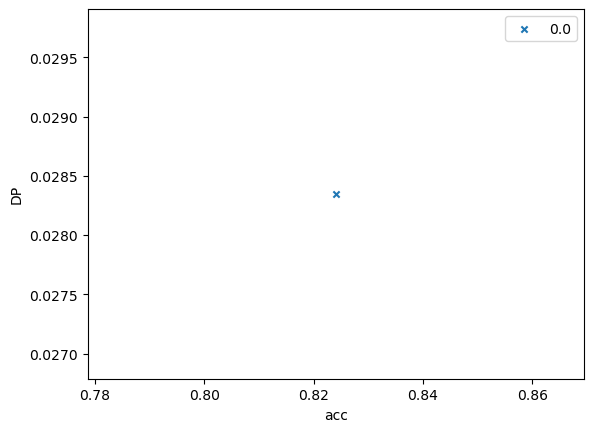

In [5]:
size = 20

dataset = "BiasedMNIST"
metric = "DP"
method = "OCS"
seed_range = [0, 1, 2, 3, 4]
epoch = 15
tau_range = [10.0]
lr_range = [0.01]
alpha_range = [0.0]
lambda_range = [0.0]

for i, lmbd in enumerate(lambda_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, [lmbd], method, metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=lmbd)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.01_tau=10.0_alpha=0.0_lmbd=0.0_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8246155641333954±0.015569907551755965
fair:0.00682430411027435±0.002236715737273572

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accurac

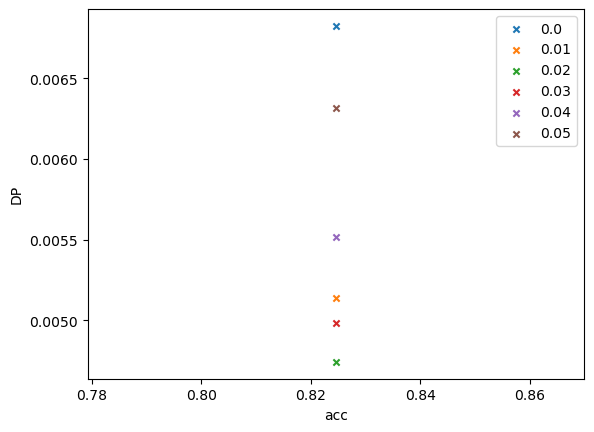

In [6]:
size = 20

dataset = "BiasedMNIST"
metric = "DP"
method = "OCS_eps_fairness"
seed_range = [0, 1, 2, 3, 4]
epoch = 15
tau_range = [10.0]
lr_range = [0.01]
alpha_range = [0.0]
lambda_range = [0.0]
# eps_range = [0.0, 0.05, 0.1, 0.15, 0.2]
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

for i, eps in enumerate(eps_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, eps_range=[eps], metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=eps)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


## BiasedMNIST iCaRL

In [7]:
# di = "scripts_output_rebuttal/dataset=BiasedMNIST/iCaRL/DP"
# for d in os.listdir(di):
#     print(d)
#     p = os.path.join(os.path.join(di, d), "log.err")
#     with open(p, "w") as f:
#         f.write("")


dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.1_tau=1.0_alpha=0.0_lmbd=0.0_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8174547710357818±0.008089707773557664
fair:0.012499904267386433±0.0034933828614096924



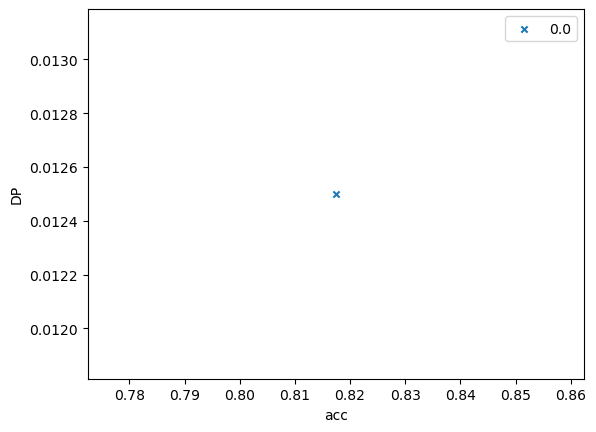

In [8]:
size = 20

dataset = "BiasedMNIST"
metric = "DP"
method = "iCaRL"
seed_range = [0, 1, 2, 3, 4]
epoch = 15
tau_range = [1.0, 5.0, 10.0]
tau_range = [1.0]
lr_range = [0.1]
alpha_range = [0.0]
lambda_range = [0.0]

for i, lmbd in enumerate(lambda_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, [lmbd], method, metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=lmbd)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.1_tau=1.0_alpha=0.0_lmbd=0.0_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8054309034290824±0.014452167802764862
fair:0.007756371487892109±0.0015162799670533644

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accurac

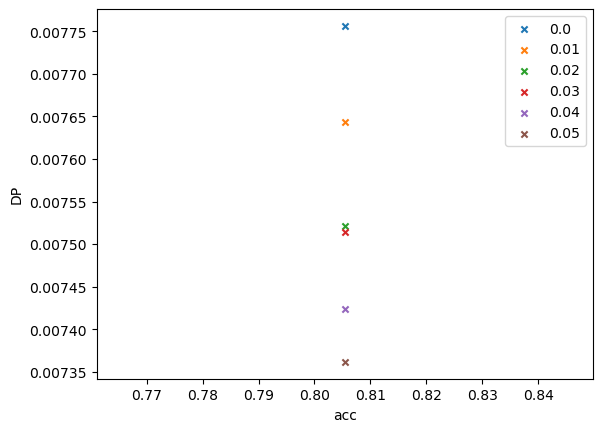

In [9]:
size = 20

dataset = "BiasedMNIST"
metric = "DP"
method = "iCaRL_eps_fairness"
seed_range = [0, 1, 2, 3, 4]
epoch = 15
tau_range = [1.0, 5.0, 10.0]
tau_range = [1.0]
lr_range = [0.1]
alpha_range = [0.0]
lambda_range = [0.0]
# eps_range = [0.0, 0.05, 0.1, 0.15, 0.2]
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

for i, eps in enumerate(eps_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, eps_range=[eps], metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=eps)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


## BiasedMNIST FSW

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.001_tau=10.0_alpha=0.01_lmbd=0.5_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8919103513160442±0.008707365567390307
fair:0.007692300464589181±0.001176791454147323



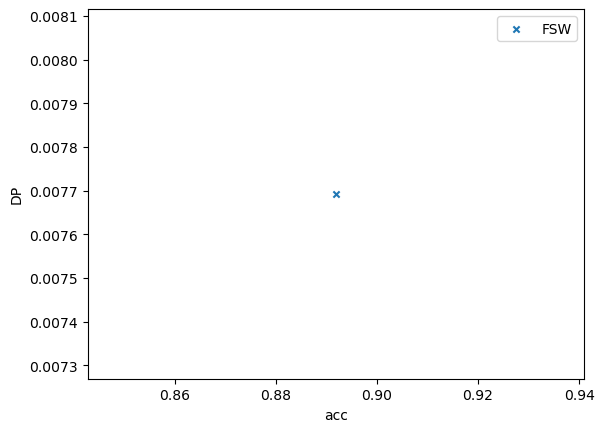

In [11]:
size = 20

dataset = "BiasedMNIST"
metric = "DP"
method = "FSW"
seed_range = [0, 1, 2, 3, 4]
epoch = 15
tau_range = [10.0]
lr_range = [0.001]
alpha_range = [0.01]
lambda_range = [0.5]

for i, lmbd in enumerate(lambda_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, [lmbd], method, metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=method)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
Error in scripts_output_rebuttal/dataset=BiasedMNIST/FSW_eps_fairness/DP/seed=4_epoch=15_lr=0.001_tau=10.0_eps=0.0_alpha=0.01_lmbd=0.5_lmbdold=0.0/log.err - error during running
Traceback (most recent call last):

  File "/mnt/shared/jaeyoung/FSSCIL/run.py", line 190, in <module>

    main()

  File "/mnt/shared/jaeyoung/FSSCIL/run.py", line 172, in main

    trainer.run()

  File "/home/jaeyoung/anaconda3/envs/cil/lib/python3.9/site-packages/cl_gym/trainer/base.py", line 105, in run

    self._run_fit()

  File "/home/jaeyoung/anaconda3/envs/cil/lib/pyt

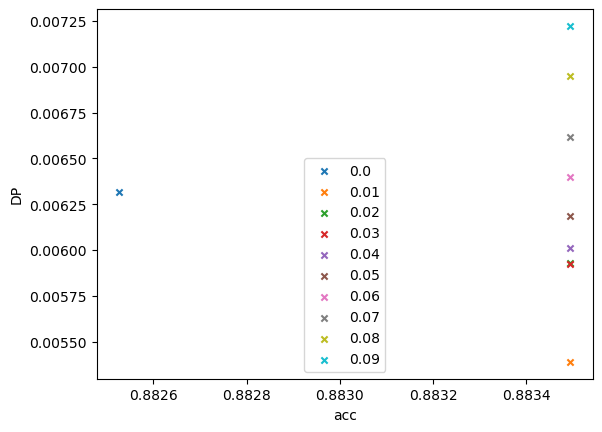

In [28]:
size = 20

dataset = "BiasedMNIST"
metric = "DP"
method = "FSW_eps_fairness"
seed_range = [0, 1, 2, 3, 4]
epoch = 15
tau_range = [10.0]
lr_range = [0.001]
alpha_range = [0.01]
lambda_range = [0.5]
# eps_range = [0.0, 0.05, 0.1, 0.15, 0.2]
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

for i, eps in enumerate(eps_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, eps_range=[eps], metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i%10], label=eps)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


# Drug

## Drug OCS

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.01_tau=10.0_alpha=0.0_lmbd=0.0_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.4295747964055224±0.006799928629064288
fair:0.07948353295485958±0.019314230626567216



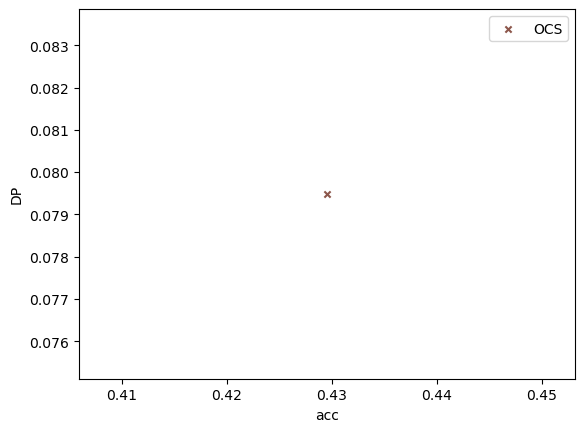

In [17]:
size = 20

dataset = "Drug"
metric = "DP"
method = "OCS"
seed_range = [0, 1, 2, 3, 4]
epoch = 25
tau_range = [10.0]
lr_range = [0.01]
alpha_range = [0.0]
lambda_range = [0.0]
# eps_range = [0.0, 0.05, 0.1, 0.15, 0.2]
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric)
plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=method)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.01_tau=10.0_alpha=0.0_lmbd=0.0_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.4309395518553109±0.020818753804186
fair:0.03259088630251134±0.0072319427456892125

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy'

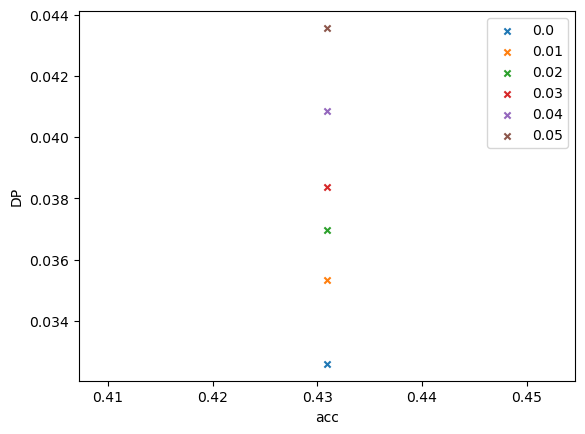

In [20]:
size = 20

dataset = "Drug"
metric = "DP"
method = "OCS_eps_fairness"
seed_range = [0, 1, 2, 3, 4]
epoch = 25
tau_range = [10.0]
lr_range = [0.01]
alpha_range = [0.0]
lambda_range = [0.0]
# eps_range = [0.0, 0.05, 0.1, 0.15, 0.2]
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

for i, eps in enumerate(eps_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, eps_range=[eps], metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=eps)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


## Drug iCaRL

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.1_tau=1.0_alpha=0.0_lmbd=0.0_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.4579937351660158±0.014099486734600946
fair:0.09826862436993855±0.019841093854672417



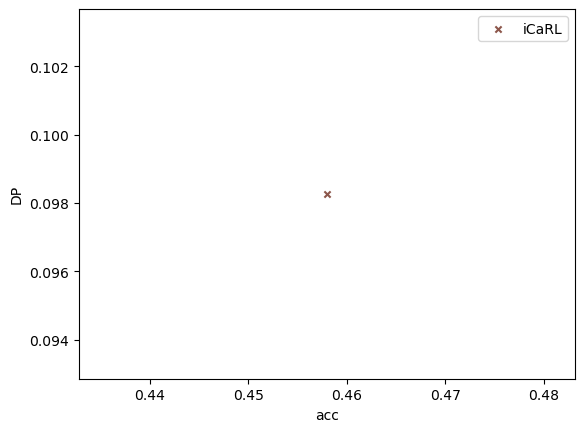

In [21]:
size = 20

dataset = "Drug"
metric = "DP"
method = "iCaRL"
seed_range = [0, 1, 2, 3, 4]
epoch = 25
tau_range = [1.0]
lr_range = [0.1]
alpha_range = [0.0]
lambda_range = [0.0]

fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric)
plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=method)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.1_tau=1.0_alpha=0.0_lmbd=0.0_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.46006099854320864±0.014542665850548064
fair:0.03516089852387884±0.01294679583411777

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy'

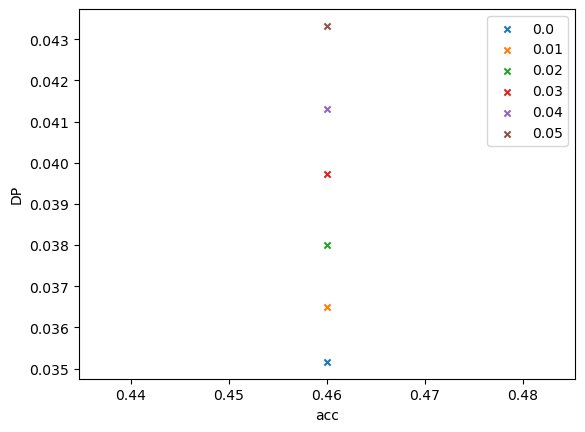

In [22]:
size = 20

dataset = "Drug"
metric = "DP"
method = "iCaRL_eps_fairness"
seed_range = [0, 1, 2, 3, 4]
epoch = 25
tau_range = [1.0]
lr_range = [0.1]
alpha_range = [0.0]
lambda_range = [0.0]
# eps_range = [0.0, 0.05, 0.1, 0.15, 0.2]
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

for i, eps in enumerate(eps_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, eps_range=[eps], metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=eps)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


## Drug FSW

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.001_tau=1.0_alpha=0.002_lmbd=0.1_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.40503464504054626±0.013145151812402308
fair:0.04292038961584509±0.0040576032351567



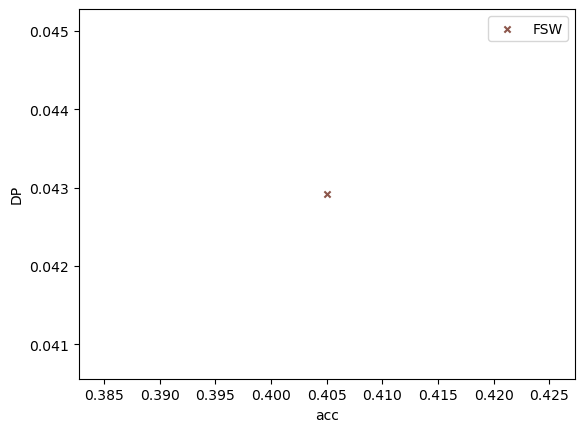

In [23]:
size = 20

dataset = "Drug"
metric = "DP"
method = "FSW"
seed_range = [0, 1, 2, 3, 4]
epoch = 25
tau_range = [1.0]
lr_range = [0.001]
alpha_range = [0.002]
lambda_range = [0.1]

fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric)
plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i], label=method)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()


dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
lr=0.001_tau=1.0_alpha=0.002_lmbd=0.1_eps=0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.4033686561382054±0.010095625067811455
fair:0.019879402064495462±0.0036464993284389346

dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_accuracy', 'EO', 'DP', 'forgetting', 'loss'])
dict_keys(['accuracy', 'accuracy_s0', 'accuracy_s1', 'classwise_acc

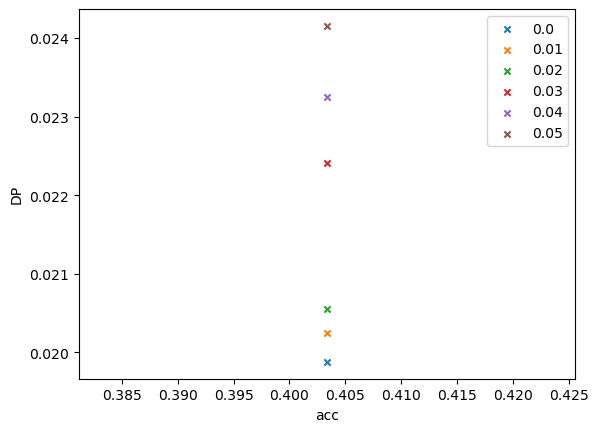

In [27]:
size = 20

dataset = "Drug"
metric = "DP"
method = "FSW_eps_fairness"
seed_range = [0, 1, 2, 3, 4]
epoch = 25
tau_range = [1.0]
lr_range = [0.001]
alpha_range = [0.002]
lambda_range = [0.1]
# eps_range = [0.0, 0.05, 0.1, 0.15, 0.2]
# eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.13, 0.15, 0.2]
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

for i, eps in enumerate(eps_range):
    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, eps_range=[eps], metric=metric)
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, c = color_list[i%10], label=eps)


plt.xlabel('acc')
if dataset in EER_dataset:
    plt.ylabel('eer')
else:
    if metric is None:
        plt.ylabel('eo')
    else:
        plt.ylabel(metric)
plt.legend()
